In [20]:
# Importing necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

### Basic decision-making rule
$$
P_{x}=\left( 1+\frac{1+as^{-(n_x-kn_y)}}{1+as^{-(n_y-kn_x)}} \right)^{-1}
\\
where 
\\
n_x = the\, number\, of\, inidivdual\, already\, chooses\, option\, x,
\\
n_y = the\, number\, of\, individual\, already\, chooses\, option\, y,
\\
a = the\, strength\, of\, nonsocial\, information,
\\
s = the\, strength\, of\, social\, information\, from\, others,\, and
\\
k = the\, relative\, impacts\, of\, opposite\, options
$$

In [2]:
def basic_rule(nx, ny, a, s, k):
    '''
    "basic_rule" calculates the proabability of a single individual to choose option x or left in this project
    based on the formula shown above. The formula was adopted from a previous work of Sara A. et al. (2012).
    It states that the probability of choosing option x becomes higher as the number of individual who chooses option x gets higher.
    In the same time, the proability becomes lower as the number of individual who chooses other option (i.e., option y) becomes higher.
    
    : param nx: the number of individual who chooses option x (or left in this project)
    : param ny: the number of individual who chooses option y (or right in this project)
    : param a: the strength of non-social information (the effect of other factors)
    : param s: the strength of social information from other individuals (i.e., information from nx and ny)
    : param k: the relative impacts of individuals who chose opposite option (i.e., option y)
    
    : return: The proability of a single individual to choose option x
    '''
    
    # Calculating the probability of a single individual to chooses option x based on the formula
    px = 1/(1+((1+a*np.float_power(s, -(nx-k*ny)))/(1+a*np.float_power(s, -(ny-k*nx)))))
    
    return px

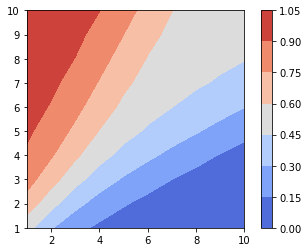

In [3]:
# Setting parameters
no_x = 10
no_y = 10
a = 2.5
s = 2.5
k = 0.53

# Setting axes
x_axis = np.linspace(1, no_x, no_x)
y_axis = np.linspace(1, no_y, no_y)

# Initializing a matrix
p_matrix = np.empty([no_x, no_y])

# Calculating probabilities for every pair of nx and ny
for x in range(no_x):
    for y in range(no_y):
        nx = x+1
        ny = y+1
        
        px = basic_rule(nx, ny, a, s, k)
        p_matrix[x, y] = px

# Plotting the p_matrix
h = plt.contourf(y_axis, x_axis, p_matrix, cmap='coolwarm')
plt.axis('scaled')
plt.colorbar()
plt.show()

<AxesSubplot:xlabel='nx'>

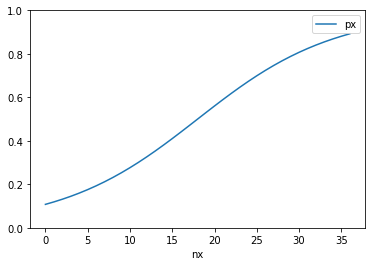

In [25]:
# Basic rule investigation
lst_nx = []
lst_px = []

a = 2.5
s = 1.07
k = 0.53

for i in range(37):
    x = i
    y = 36-i
    
    px = basic_rule(x, y, a, s, k)
    lst_nx.append(i)
    lst_px.append(px)
    
df_inv = pd.DataFrame({
    'nx': lst_nx,
    'px': lst_px
})

df_inv.plot(x='nx', y='px', ylim=[0, 1])

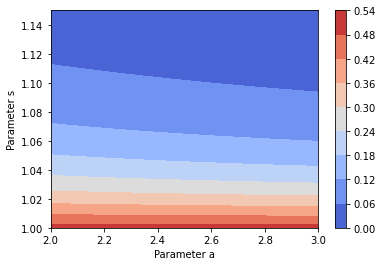

In [54]:
# Setting axes
a_axis = np.linspace(2, 3, 100)
s_axis = np.linspace(1, 1.15, 100)

a, s = np.meshgrid(a_axis, s_axis)

p = basic_rule(0, 36, a, s, 0.53)

plt.contourf(a, s, p, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Parameter a')
plt.ylabel('Parameter s')
plt.show()

In [5]:
def initialize_b(X, Y):
    '''
    "initialize" function initializes a 2-D grid. Each cell or ant chooses either going left or right randomly.
    
    : param X: Number of rows in a 2-D grid
    : param Y: number of columns in a 2-D grid
    
    : return: Initialized 2-D decision grid
    '''
    # Initializing 2 2-D grid
    decision_grid = np.zeros((X, Y))
    sh = decision_grid.shape
    
    # Randomly initializing the decision for each cell
    # going left: 0, going right: 1
    for x in range(sh[0]):
        for y in range(sh[1]):
            dec = random.randint(0, 1)
            decision_grid[x][y] = dec
            
    return decision_grid

In [6]:
def cal_collective_mv_b(grid, damp):
    '''
    "cal_collective_mv" function calculates the collective movement speed of a group of ants.
    In this project, the speed follows a tanh function that takes the difference between numbers of ants who choose option x and y.
    So, the speed ranges from -1 and 1 where minus value means going left and plus value means going right.
    The higher the difference between numbers of ants for each direction, the faster the collevtive movement is.
    
    : param grid: The 2-D grid of which the colletive movement speed is calculated.
    : param damp: A parameter that controls the changing rate of collective speed. 
                  The lower the value is, the smaller the change rate is.
    
    : return: Calculated collective movement speed of a group of ants 
              along with numbers of ants who choose option x (i.e., moving left) and option y (i.e., moving right)
    '''
    sh = grid.shape
    
    # Initializing numbers of ants choosing either option x or y
    left = 0
    right = 0
    
    # Counting numbers of ants choosing option x or y
    for x in range(sh[0]):
        for y in range(sh[1]):
            if grid[x][y] == 0:
                left+=1
            else:
                right+=1
    
    # Calculating the difference
    z = right - left
    # Applying damping parameter
    z = z*damp
    # Calculating the final speed
    # going left: -1<=speed<=0
    # going right: 0<=spped<=1
    speed = (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    
    return speed, left, right

In [7]:
def update_b(grid_o, damp, a, s, k):
    '''
    "update" function updates values in 2-D grid with current 2-D grid status.
     It updates a decision of an individual to go right or left based the numbers of ants choosing each option.
    
    : param grid_o: The 2-D decision grid of previous step.
    : param damp: A parameter that controls the changing rate of collective speed.
    : param a: the strength of non-social information (the effect of other factors)
    : param s: the strength of social information from other individuals (i.e., information from nx and ny)
    : param k: the relative impacts of individuals who chose opposite option (i.e., option y)
    
    : return: An updated grid_c for the next step with next decisions. 
    '''
    
    # Getting the shape of the grid
    sh = grid_o.shape
    # Getting speed and numbers of each choice from the grid
    speed, left, right = cal_collective_mv_b(grid_o, damp)
    # Copying the grid
    grid_c = np.copy(grid_o)
    
    for x in range(sh[0]):
        for y in range(sh[1]):                    
            # Updating decisions according to the number of ants choosing each option
            nx, ny = left, right
            px = basic_rule(nx, ny, a, s, k)
            grid_c[x][y] = random.choices((0, 1), [px, 1-px])[0]
    
    return grid_c, px

In [8]:
# Simulate

# Parameter
a = 2.5
s = 1.10
k = 0.53
damp = 0.1

# Length of barriers
barriers = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 75]

# Number of simulation trials
trials = 1000
# Number of steps in each trials
steps = 100

# Grid size
X, Y = 6, 6

lst_no_normal = []
lst_no_sharp_turn = []
lst_sum_no_diff_normal = []
lst_sum_no_diff_sharp_turn = []
lst_sum_normal_mv_diff = []
lst_sum_sharp_turn_diff = []
lst_no_left = []
lst_no_right = []
lst_speed_left = []
lst_speed_right = []
lst_no_steps = []


for trial in range(trials):
    # Initializing the decision-grid
    grid = initialize_b(6, 6)
    
    # list of results
    lst_speed = []
    lst_left = []
    lst_right = []
    lst_px = []
    
    for i in range(steps):
        # Getting results from current grid status
        speed, left, right = cal_collective_mv_b(grid, damp)
        lst_speed.append(speed)
        lst_left.append(left)
        lst_right.append(right)

        # Updating the grid status
        grid, px = update_b(grid, damp, a, s, k)
        lst_px.append(px)
    
    # Dataframe for the results
    df = pd.DataFrame(
        {
            "speed": lst_speed,
            "no of choosing left": lst_left,
            "no of choosing right": lst_right,
            "px": lst_px
        }
    )
    
    # Marking left or right
    df['left or right'] = (df['speed']>0).astype('int')

    # Marking sharp turn
    df['sharp turn'] = (df.shift()['speed']*df['speed']<0).astype('int')
    df['sharp turn diff'] = abs(df.diff()['speed'])
    df['sharp turn number diff (left)'] = abs(df.diff()['no of choosing left'])
    
    # Calculating number of steps to escape the barrier
    no_steps = {}
    
    for barrier in barriers:
        if len(df[abs(df['speed'].cumsum())>barrier])==0:
            break
        else:
            no_step = df[abs(df['speed'].cumsum())>barrier].iloc[0].name
            no_steps[barrier] = no_step
    
    # Summarizing results
    no_turn = df.groupby('sharp turn')['sharp turn'].count()
    sum_diff = df.groupby('sharp turn')['sharp turn diff'].sum()
    sum_no_diff = df.groupby('sharp turn')['sharp turn number diff (left)'].sum()
    no_mv = df.groupby('left or right')['speed'].count()
    sum_speed = df.groupby('left or right')['speed'].sum()
    
    
    if len(no_turn)<2:
        no_normal = no_turn[0]
        no_sharp_turn = 0
    else:
        no_normal = no_turn[0]
        no_sharp_turn = no_turn[1]
        
    if len(sum_diff)<2:
        sum_normal_mv_diff = sum_diff[0]
        sum_sharp_turn_diff = 0
    else:
        sum_normal_mv_diff = sum_diff[0]
        sum_sharp_turn_diff = sum_diff[1]
    
    if len(sum_no_diff)<2:
        no_diff_normal = sum_no_diff[0]
        no_diff_sharp_turn = 0
    else:
        no_diff_normal = sum_no_diff[0]
        no_diff_sharp_turn = sum_no_diff[1]
    
    if 0 in no_mv.index:
        no_left = no_mv[0]
    else:
        no_left = 0
    if 1 in no_mv.index:
        no_right = no_mv[1]
    else:
        no_right = 0
    
    if 0 in sum_speed.index:
        speed_left = sum_speed[0]
    else:
        speed_left = 0
    if 1 in sum_speed.index:
        speed_right = sum_speed[1]
    else:
        speed_right = 0
    
    # Appending results
    lst_no_normal.append(no_normal)
    lst_no_sharp_turn.append(no_sharp_turn)
    lst_sum_no_diff_normal.append(no_diff_normal)
    lst_sum_no_diff_sharp_turn.append(no_diff_sharp_turn)
    lst_sum_normal_mv_diff.append(sum_normal_mv_diff)
    lst_sum_sharp_turn_diff.append(sum_sharp_turn_diff)
    lst_no_left.append(no_left)
    lst_no_right.append(no_right)
    lst_speed_left.append(speed_left)
    lst_speed_right.append(speed_right)
    lst_no_steps.append(no_steps)

df_sim_b = pd.DataFrame(
    {
        "no_normal": lst_no_normal,
        "no_sharp_turn": lst_no_sharp_turn,
        "sum_no_diff_normal": lst_sum_no_diff_normal,
        "sum_no_diff_sharp_turn": lst_sum_no_diff_sharp_turn,
        "sum_normal_mv_diff": lst_sum_normal_mv_diff,
        "sum_sharp_turn_diff": lst_sum_sharp_turn_diff,
        "no_left": lst_no_left,
        "no_right": lst_no_right,
        "speed_left": lst_speed_left,
        "speed_right": lst_speed_right,
        "no_steps": lst_no_steps
    }
)

df_sim_b

,no_normal,no_sharp_turn,sum_no_diff_normal,sum_no_diff_sharp_turn,sum_normal_mv_diff,sum_sharp_turn_diff,no_left,no_right,speed_left,speed_right,no_steps
0,100,0,171.0,0.0,3.244160,0.000000,1,99,0.000000,93.989452,"{0.5: 1, 1: 2, 1.5: 3, 2: 4, 3: 6, 4: 8, 5: 9,..."
1,100,0,151.0,0.0,1.251351,0.000000,100,0,-97.955301,0.000000,"{0.5: 0, 1: 1, 1.5: 2, 2: 2, 3: 3, 4: 4, 5: 5,..."
2,98,2,181.0,10.0,3.212029,1.833997,98,2,-92.323006,0.759898,"{0.5: 1, 1: 2, 1.5: 3, 2: 7, 3: 8, 4: 10, 5: 1..."
3,99,1,169.0,7.0,2.362459,1.201086,1,99,-0.664037,93.851688,"{0.5: 0, 1: 5, 1.5: 6, 2: 7, 3: 8, 4: 9, 5: 10..."
4,100,0,178.0,0.0,1.579184,0.000000,0,100,0.000000,97.526948,"{0.5: 1, 1: 2, 1.5: 2, 2: 3, 3: 4, 4: 5, 5: 6,..."
...,...,...,...,...,...,...,...,...,...,...,...
995,100,0,164.0,0.0,0.996357,0.000000,0,100,0.000000,98.153697,"{0.5: 0, 1: 1, 1.5: 1, 2: 2, 3: 3, 4: 4, 5: 5,..."
996,99,1,150.0,3.0,1.499691,0.577324,1,99,-0.197375,96.742346,"{0.5: 2, 1: 2, 1.5: 3, 2: 4, 3: 5, 4: 6, 5: 7,..."
997,100,0,160.0,0.0,1.631779,0.000000,100,0,-96.800068,0.000000,"{0.5: 1, 1: 1, 1.5: 2, 2: 3, 3: 4, 4: 5, 5: 6,..."
998,97,3,159.0,12.0,1.686565,2.203275,94,6,-91.452163,3.234155,"{0.5: 2, 1: 3, 1.5: 4, 2: 5, 3: 6, 4: 14, 5: 1..."


In [9]:
df_sim_b.describe()

,no_normal,no_sharp_turn,sum_no_diff_normal,sum_no_diff_sharp_turn,sum_normal_mv_diff,sum_sharp_turn_diff,no_left,no_right,speed_left,speed_right
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,99.624000,0.376000,167.4560,1.428000,1.928009,0.259038,49.844000,50.156000,-47.810448,48.507717
std,0.731546,0.731546,14.7884,2.764862,0.973367,0.497157,48.699479,48.699479,47.532429,47.589705
min,95.000000,0.000000,127.0000,0.000000,0.492640,0.000000,0.000000,0.000000,-99.075554,0.000000
25%,99.000000,0.000000,157.0000,0.000000,1.273002,0.000000,0.000000,0.000000,-96.798730,0.000000
50%,100.000000,0.000000,167.0000,0.000000,1.679205,0.000000,32.000000,68.000000,-27.384743,64.863766
75%,100.000000,1.000000,177.0000,2.000000,2.366690,0.394751,100.000000,100.000000,0.000000,96.945590
max,100.000000,5.000000,228.0000,17.000000,6.720227,3.119763,100.000000,100.000000,0.000000,99.025533


### Decision-making rule with decaying preference
$$
P_{x}=\left( 1+\frac{1+as^{-(n_x*Decay(t_x)-k*n_y)}}{1+as^{-(n_y*Decay(t_y)-k*n_x)}} \right)^{-1}
$$


$$
Decay(t_x)= e^{\frac{-t_x^{2}}{\lambda^2}}
\\
Decay(t_y)= e^{\frac{-t_y^{2}}{\lambda^2}}
$$

where  
$n_x$ is the number of inidivduals already chosen option $x$,  
$n_y$ is the number of individuals already chosen option $y$,  
$a$ is the strength of nonsocial information,  
$s$ is the strength of social information from others,  
$k$ is the relative impacts of opposite options,  
$\lambda$ is the preference decaying paramter,  
$t_x$ is the elapsed time without any rewards on choosing option $x$   
$t_y$ is the elapsed time without any rewards on choosing option $y$  

$t_{x}$ and $t_{y}$ are set back to zero when each individual gets rewards or chooses different option

In [10]:
def modified_rule(nx, ny, a, s, k, lm, tx, ty):
    '''
    "modified_rule" calculates the proabability of a single individual to choose option x or left in this project
    based on the modified formula shown above. Three additional parameters are added to the modified formula; lm, tx, and ty.
    tx and ty are used to calculate the decaying rate of nx and ny, respectively. The higher the value of tx (or ty) becomes, 
    the lower the effect of nx (or ny, respectively) becomes. The decaying rate is determined by parameter lm.
    Also, the decaying rate is exponentially increaesd with the sqaure of tx (or ty, respectively).
    Note that either tx or ty could be greater than zero meaning they are set back to zero where each individual gets rewards or chooses the opposite option.
    
    : param nx: the number of individual who chooses option x (or left in this project)
    : param ny: the number of individual who chooses option y (or right in this project)
    : param a: the strength of non-social information (the effect of other factors)
    : param s: the strength of social information from other individuals (i.e., information from nx and ny)
    : param k: the relative impacts of individuals who chose opposite option (i.e., option y)
    : param lm: the decaying rate parameter of nx (or ny) with regard to tx (or ty, respectively)
    : param tx: the elapsed time without any rewards while choosing and moving to option x
    : param ty: the elapsed time without any rewards while choosing and moving to option y   
    
    : return: The proability of a single individual to choose option x
    '''
    
    # if both tx and ty are greater than zero, return None
    if tx*ty!=0:
        return None
    
    # Calculating the probability of a single individual to chooses option x based on the formula
    decay_x = nx*np.exp(-np.power(tx, 2)/(np.power(lm, 2)))
    decay_y = ny*np.exp(-np.power(ty, 2)/(np.power(lm, 2)))
    dx = 1 + a*np.float_power(s, -(decay_x-k*ny))
    dy = 1 + a*np.float_power(s, -(decay_y-k*nx))    
    px = 1/(1+(dx/dy))
    
    return px

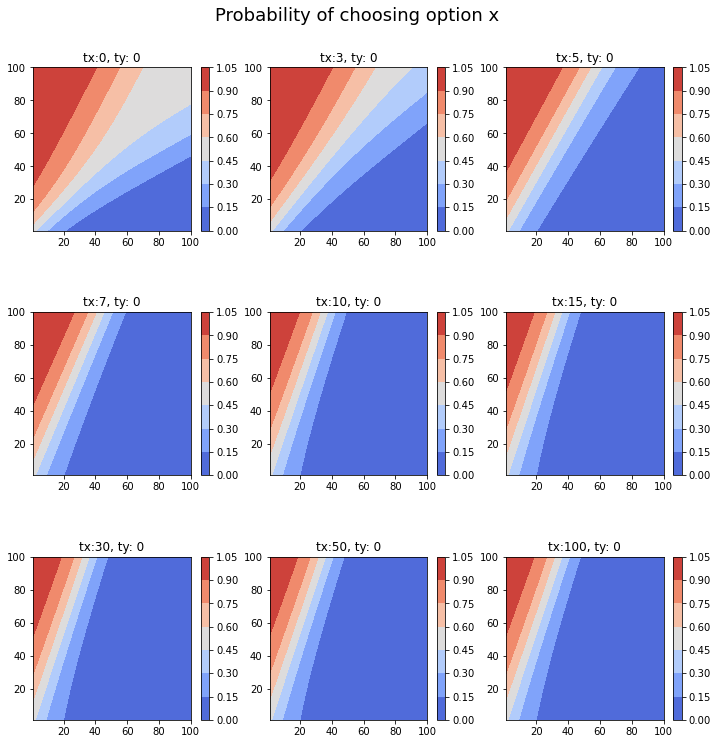

In [11]:
# Setting parameters
no_x = 100
no_y = 100
a = 2.5
s = 1.10
k = 0.53
lm = 5
txty_lst = [(0, 0), (3, 0), (5, 0), (7, 0), (10, 0), (15, 0), (30, 0), (50, 0), (100, 0)]

# Setting axes
x_axis = np.linspace(1, no_x, no_x)
y_axis = np.linspace(1, no_y, no_y)

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Probability of choosing option x", fontsize=18, y=0.95)

# Plot p_matrix for each (tx, ty) pair 
for txty, ax in zip(txty_lst, axs.ravel()):
    (tx, ty) = txty
    
    # Initializing a matrix
    p_matrix = np.empty([no_x, no_y])
    
    # Calculating probabilities for every pair of nx and ny
    for x in range(no_x):
        for y in range(no_y):
            nx = x+1
            ny = y+1

            px = modified_rule(nx, ny, a, s, k, lm, tx, ty)
            p_matrix[x, y] = px
    
    # Plotting the p_matrix
    im = ax.contourf(y_axis, x_axis, p_matrix, cmap='coolwarm')
    ax.title.set_text('tx:' + str(tx) + ', ty: ' + str(ty))
    plt.colorbar(im, ax=ax)

plt.show()

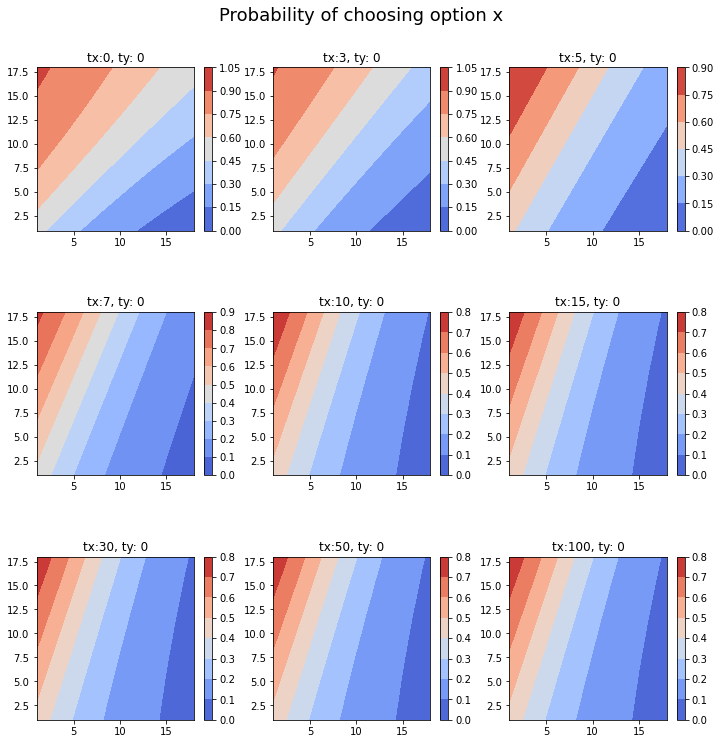

In [12]:
# Probability of choosing option x when number of ants are relatively small (<18)
# Setting parameters
no_x = 18
no_y = 18
a = 2.5
s = 1.2
k = 0.53
lm = 5
txty_lst = [(0, 0), (3, 0), (5, 0), (7, 0), (10, 0), (15, 0), (30, 0), (50, 0), (100, 0)]

# Setting axes
x_axis = np.linspace(1, no_x, no_x)
y_axis = np.linspace(1, no_y, no_y)

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Probability of choosing option x", fontsize=18, y=0.95)

# Plot p_matrix for each (tx, ty) pair 
for txty, ax in zip(txty_lst, axs.ravel()):
    (tx, ty) = txty
    
    # Initializing a matrix
    p_matrix = np.empty([no_x, no_y])
    
    # Calculating probabilities for every pair of nx and ny
    for x in range(no_x):
        for y in range(no_y):
            nx = x+1
            ny = y+1

            px = modified_rule(nx, ny, a, s, k, lm, tx, ty)
            p_matrix[x, y] = px
    
    # Plotting the p_matrix
    im = ax.contourf(y_axis, x_axis, p_matrix, cmap='coolwarm')
    ax.title.set_text('tx:' + str(tx) + ', ty: ' + str(ty))
    plt.colorbar(im, ax=ax)

plt.show()

### Modeling ants' decisions
A 2-D grid where each cell represents an individual ant's decision is used to show the collective decision of ants.
Each cell has three values; the decision that was made by the probability model defined above, elapsed time without any rewards while choosing an option x or moving left in this project (i.e., tx), 
and elapsed time without rewards while choosing the opposite option or moving right (i.e., ty).

Three functions are defined in this part:  
`initialize(X, Y, dim)`: Initialize the grid, each cell chooses either left or right, elapsed times (tx, ty) are set to zero  
`cal_collective_mv(grid, damp)`: Collective movement speed is calculated based on the current status of the grid  
`update(grid_o, speed, left, right, reward, a, s, k, lm)`: New decisions are made based on the current status of the grid   

In [13]:
def initialize(X, Y, dim):
    '''
    "initialize" function initializes a 2-D grid. Each cell or ant chooses either going left or right randomly.
    Elapsed times (i.e., tx and ty) of every ant are set to zero.
    
    : param X: Number of rows in a 2-D grid
    : param Y: number of columns in a 2-D grid
    : param dim: number of dimensions describing the status of an individual cell, could be extended
                 In this project, there are three values to describe the status:
                 decision_grid[i][j][0] => the decision made by an ant in grid[i, j], 0: going left, 1: going right
                 decision_grid[i][j][1] => the elapsed time without rewards while going left
                 decision_grid[i][j][2] => the elapsed time without rewards while going right
    
    : return: Initialized 2-D decision grid
    '''
    # Initializing 2 2-D grid
    decision_grid = np.zeros((X, Y, dim))
    sh = decision_grid.shape
    
    # Randomly initializing the decision for each cell
    # going left: 0, going right: 1
    for x in range(sh[0]):
        for y in range(sh[1]):
            dec = random.randint(0, 1)
            decision_grid[x][y][0] = dec
            
    return decision_grid

In [14]:
def cal_collective_mv(grid, damp):
    '''
    "cal_collective_mv" function calculates the collective movement speed of a group of ants.
    In this project, the speed follows a tanh function that takes the difference between numbers of ants who choose option x and y.
    So, the speed ranges from -1 and 1 where minus value means going left and plus value means going right.
    The higher the difference between numbers of ants for each direction, the faster the collevtive movement is.
    
    : param grid: The 2-D grid of which the colletive movement speed is calculated.
    : param damp: A parameter that controls the changing rate of collective speed. 
                  The lower the value is, the smaller the change rate is.
    
    : return: Calculated collective movement speed of a group of ants 
              along with numbers of ants who choose option x (i.e., moving left) and option y (i.e., moving right)
    '''
    sh = grid.shape
    
    # Initializing numbers of ants choosing either option x or y
    left = 0
    right = 0
    
    # Counting numbers of ants choosing option x or y
    for x in range(sh[0]):
        for y in range(sh[1]):
            if grid[x][y][0] == 0:
                left+=1
            else:
                right+=1
    
    # Calculating the difference
    z = right - left
    # Applying damping parameter
    z = z*damp
    # Calculating the final speed
    # going left: -1<=speed<=0
    # going right: 0<=spped<=1
    speed = (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    
    return speed, left, right

In [15]:
def update(grid_o, damp, reward, a, s, k, lm):
    '''
    "update" function updates values in 2-D grid with current 2-D grid status.
    First, it updates the elapsed time accordingly (e.g., if the collective movement is right and there is no reward, it increases tx by 1).
    Then, it updates a decision of an individual to go right or left based the numbers of ants choosing each option.
    
    : param grid_o: The 2-D decision grid of previous step.
    : param damp: A parameter that controls the changing rate of collective speed.
    : param reward: A reward from a collective movement that is from external mechanism. In this project, it is always 0 for the simplicity. Could be extended with rewards mechanism.
    : param a: the strength of non-social information (the effect of other factors)
    : param s: the strength of social information from other individuals (i.e., information from nx and ny)
    : param k: the relative impacts of individuals who chose opposite option (i.e., option y)
    : param lm: the decaying rate parameter of nx (or ny) with regard to tx (or ty, respectively)
    
    : return: An updated grid_c for the next step with next decisions and elapsed times. 
    '''
    
    # Getting the shape of the grid
    sh = grid_o.shape
    # Getting speed and numbers of each choice from the grid
    speed, left, right = cal_collective_mv(grid_o, damp)
    # Copying the grid
    grid_c = np.copy(grid_o)
    
    for x in range(sh[0]):
        for y in range(sh[1]):
            # Updating elapsed times
            # if there is a reward, then reset all elapsed times
            if reward>0:
                grid_c[x][y][1] = 0
                grid_c[x][y][2] = 0
            else:
                # if currently moving right without any rewards
                if speed>0:
                    grid_c[x][y][2] += 1
                    grid_c[x][y][1] = 0
                # if currently moving left without any rewards
                else:
                    grid_c[x][y][1] += 1
                    grid_c[x][y][2] = 0
                    
            # Updating decisions according to the number of ants choosing each option
            nx, ny = left, right
            tx, ty = grid_c[x][y][1], grid_c[x][y][2]
            px = modified_rule(nx, ny, a, s, k, lm, tx, ty)
            
            grid_c[x][y][0] = random.choices((0, 1), [px, 1-px])[0]
            
    return grid_c

### Simulation

In [16]:
# Simulation

# Number of simulations
N_sim = 1000

# Number of steps in each simulation
N = 100

# Length of barriers
barriers = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Setting parameters
a = 2.5
s = 1.10
k = 0.53
lm = 10
damp = 0.1
reward = 0

lst_no_normal = []
lst_no_sharp_turn = []
lst_sum_no_diff_normal = []
lst_sum_no_diff_sharp_turn = []
lst_sum_normal_mv_diff = []
lst_sum_sharp_turn_diff = []
lst_no_left = []
lst_no_right = []
lst_speed_left = []
lst_speed_right = []
lst_no_steps = []

for i in range(N_sim):
    
    # initialize
    X, Y, dim = 6, 6, 3
    grid = initialize(X, Y, dim)
    
    # list of results
    lst_speed = []
    lst_left = []
    lst_right = []
    
    for i in range(N):
        # Getting results from current grid status
        speed, left, right = cal_collective_mv(grid, damp)
        lst_speed.append(speed)
        lst_left.append(left)
        lst_right.append(right)

        # Updating the grid status
        grid = update(grid, damp, reward, a, s, k, lm) 
    
    # Dataframe for the results
    df = pd.DataFrame(
        {
            "speed": lst_speed,
            "no of choosing left": lst_left,
            "no of choosing right": lst_right,
        }
    )
    
    # Marking left or right
    df['left or right'] = (df['speed']>0).astype('int')

    # Marking sharp turn
    df['sharp turn'] = (df.shift()['speed']*df['speed']<0).astype('int')
    df['sharp turn diff'] = abs(df.diff()['speed'])
    df['sharp turn number diff (left)'] = abs(df.diff()['no of choosing left'])
    
    # Calculating number of steps to escape the barrier
    no_steps = []
    
    for barrier in barriers:
        if len(df[abs(df['speed'].cumsum())>barrier])==0:
            break
        else:
            no_step = df[abs(df['speed'].cumsum())>barrier].iloc[0].name
            no_steps.append((barrier, no_step))
    
    # Summarizing results
    no_turn = df.groupby('sharp turn')['sharp turn'].count()
    sum_diff = df.groupby('sharp turn')['sharp turn diff'].sum()
    sum_no_diff = df.groupby('sharp turn')['sharp turn number diff (left)'].sum()
    no_mv = df.groupby('left or right')['speed'].count()
    sum_speed = df.groupby('left or right')['speed'].sum()
    
    if len(no_turn)<2:
        no_normal = no_turn[0]
        no_sharp_turn = 0
    else:
        no_normal = no_turn[0]
        no_sharp_turn = no_turn[1]
        
    if len(sum_diff)<2:
        sum_normal_mv_diff = sum_diff[0]
        sum_sharp_turn_diff = 0
    else:
        sum_normal_mv_diff = sum_diff[0]
        sum_sharp_turn_diff = sum_diff[1]
    
    if len(sum_no_diff)<2:
        no_diff_normal = sum_no_diff[0]
        no_diff_sharp_turn = 0
    else:
        no_diff_normal = sum_no_diff[0]
        no_diff_sharp_turn = sum_no_diff[1]
    
    if 0 in no_mv.index:
        no_left = no_mv[0]
    else:
        no_left = 0
    if 1 in no_mv.index:
        no_right = no_mv[1]
    else:
        no_right = 0
    
    if 0 in sum_speed.index:
        speed_left = sum_speed[0]
    else:
        speed_left = 0
    if 1 in sum_speed.index:
        speed_right = sum_speed[1]
    else:
        speed_right = 0
    
    # Appending results
    lst_no_normal.append(no_normal)
    lst_no_sharp_turn.append(no_sharp_turn)
    lst_sum_no_diff_normal.append(no_diff_normal)
    lst_sum_no_diff_sharp_turn.append(no_diff_sharp_turn)
    lst_sum_normal_mv_diff.append(sum_normal_mv_diff)
    lst_sum_sharp_turn_diff.append(sum_sharp_turn_diff)
    lst_no_left.append(no_left)
    lst_no_right.append(no_right)
    lst_speed_left.append(speed_left)
    lst_speed_right.append(speed_right)
    lst_no_steps.append(no_steps)

df_sim = pd.DataFrame(
    {
        "no_normal": lst_no_normal,
        "no_sharp_turn": lst_no_sharp_turn,
        "sum_no_diff_normal": lst_sum_no_diff_normal,
        "sum_no_diff_sharp_turn": lst_sum_no_diff_sharp_turn,
        "sum_normal_mv_diff": lst_sum_normal_mv_diff,
        "sum_sharp_turn_diff": lst_sum_sharp_turn_diff,
        "no_left": lst_no_left,
        "no_right": lst_no_right,
        "speed_left": lst_speed_left,
        "speed_right": lst_speed_right,
        "no_steps": lst_no_steps
    }
)

df_sim

,no_normal,no_sharp_turn,sum_no_diff_normal,sum_no_diff_sharp_turn,sum_normal_mv_diff,sum_sharp_turn_diff,no_left,no_right,speed_left,speed_right,no_steps
0,88,12,194.0,75.0,10.406703,11.785663,55,45,-41.197452,38.064509,"[(0.5, 4), (1, 9), (1.5, 10), (2, 10), (3, 11)..."
1,85,15,175.0,75.0,12.602473,12.638927,55,45,-36.782384,30.052708,"[(0.5, 4), (1, 5), (1.5, 11), (2, 11), (3, 13)..."
2,91,9,225.0,62.0,13.015283,9.308485,39,61,-23.173384,51.307736,"[(0.5, 0), (1, 1), (1.5, 2), (2, 2), (3, 3), (..."
3,91,9,196.0,52.0,14.855261,8.445972,45,55,-27.798823,40.739142,"[(0.5, 0), (1, 1), (1.5, 1), (2, 2), (3, 12), ..."
4,91,9,184.0,64.0,10.415556,9.892106,59,41,-44.777001,29.981535,"[(0.5, 2), (1, 3), (1.5, 3), (2, 11), (3, 12),..."
...,...,...,...,...,...,...,...,...,...,...,...
995,89,11,203.0,73.0,11.716001,11.766881,27,73,-17.162780,61.014816,"[(0.5, 0), (1, 1), (1.5, 2), (2, 3), (3, 11), ..."
996,90,10,178.0,56.0,12.165732,9.295527,44,56,-26.531332,45.198750,"[(0.5, 0), (1, 1), (1.5, 2), (2, 2), (3, 26), ..."
997,90,10,194.0,67.0,10.990977,10.257609,48,52,-36.240040,40.042794,"[(0.5, 0), (1, 1), (1.5, 2), (2, 2), (3, 3), (..."
998,85,15,191.0,70.0,11.576744,11.865938,62,38,-44.376158,25.895871,"[(0.5, 0), (1, 1), (1.5, 2), (2, 2), (3, 3), (..."


In [17]:
df_sim.describe()

,no_normal,no_sharp_turn,sum_no_diff_normal,sum_no_diff_sharp_turn,sum_normal_mv_diff,sum_sharp_turn_diff,no_left,no_right,speed_left,speed_right
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,90.481000,9.519000,205.02600,60.504000,11.625697,9.458097,48.056000,51.944000,-35.394905,42.033009
std,2.199654,2.199654,18.18026,11.520013,2.112249,1.798024,7.014133,7.014133,7.410890,7.025156
min,82.000000,4.000000,148.00000,26.000000,6.157816,4.282812,25.000000,29.000000,-60.970174,20.874981
25%,89.000000,8.000000,194.00000,53.000000,10.114597,8.235977,43.000000,47.000000,-40.446707,37.280167
50%,91.000000,9.000000,205.50000,60.000000,11.512849,9.434637,48.000000,52.000000,-35.642709,41.846556
75%,92.000000,11.000000,217.00000,69.000000,12.943676,10.699968,53.000000,57.000000,-30.813739,46.699008
max,96.000000,18.000000,263.00000,98.000000,20.466863,15.366962,71.000000,75.000000,-10.643049,64.866055


count    1000.000000
mean        9.519000
std         2.199654
min         4.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        18.000000
Name: no_sharp_turn, dtype: float64


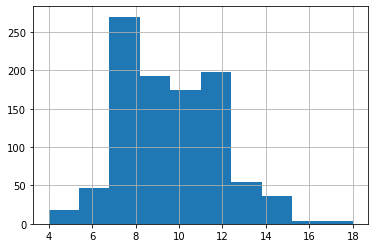

In [18]:
# Number of sharp turns during the simulation
df_sim['no_sharp_turn'].hist()
print(df_sim['no_sharp_turn'].describe())

<AxesSubplot:>

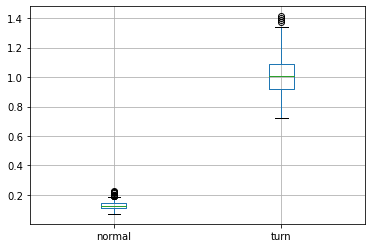

In [19]:
# Comparing speed changes
tmp_df = pd.DataFrame()
tmp_df['normal'] = (df_sim['sum_normal_mv_diff']/df_sim['no_normal'])
tmp_df['turn'] = (df_sim['sum_sharp_turn_diff']/df_sim['no_sharp_turn'])
tmp_df.boxplot()

In [27]:
tmp_df.describe()

,normal,turn
count,1000.000000,1000.000000
mean,0.128515,1.008693
std,0.023281,0.120098
min,0.070779,0.724731
25%,0.111804,0.919388
50%,0.127091,1.008883
75%,0.143527,1.090033
max,0.224911,1.412958


In [24]:
stat = pd.DataFrame()
stat['turn'] = (df_sim['sum_sharp_turn_diff']/df_sim['no_sharp_turn']).describe()
stat['normal'] = (df_sim['sum_normal_mv_diff']/df_sim['no_normal']).describe()
stat

,turn,normal
count,1000.000000,1000.000000
mean,1.008693,0.128515
std,0.120098,0.023281
min,0.724731,0.070779
25%,0.919388,0.111804
50%,1.008883,0.127091
75%,1.090033,0.143527
max,1.412958,0.224911


In [23]:
stats.ttest_ind(tmp_df['normal'], tmp_df['turn'], trim=.2)

Ttest_indResult(statistic=-203.34467086881727, pvalue=0.0)

<AxesSubplot:>

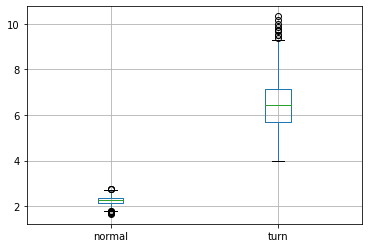

In [21]:
# Comparing the number of ants who changed their decisions
tmp_df2 = pd.DataFrame()
tmp_df2['normal'] = (df_sim['sum_no_diff_normal']/df_sim['no_normal'])
tmp_df2['turn'] = (df_sim['sum_no_diff_sharp_turn']/df_sim['no_sharp_turn'])
tmp_df2.boxplot()

In [26]:
tmp_df2.describe()

,normal,turn
count,1000.000000,1000.000000
mean,2.264635,6.493903
std,0.177711,1.079530
min,1.662921,4.000000
25%,2.147312,5.700000
50%,2.268817,6.454545
75%,2.382022,7.142857
max,2.768421,10.333333


<AxesSubplot:>

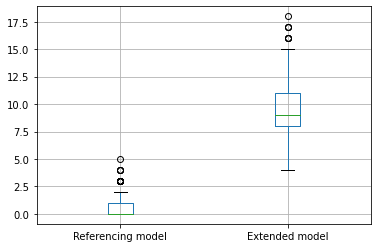

In [29]:
# Comparison

df_com = pd.DataFrame()
df_com['Referencing model'] = df_sim_b['no_sharp_turn']
df_com['Extended model'] = df_sim['no_sharp_turn']

df_com.boxplot()

In [30]:
df_com.describe()

,Referencing model,Extended model
count,1000.000000,1000.000000
mean,0.376000,9.519000
std,0.731546,2.199654
min,0.000000,4.000000
25%,0.000000,8.000000
50%,0.000000,9.000000
75%,1.000000,11.000000
max,5.000000,18.000000


In [34]:
stats.ttest_ind(df_com['Referencing model'], df_com['Extended model'], trim=.2)

Ttest_indResult(statistic=-134.8232564411396, pvalue=0.0)

<AxesSubplot:>

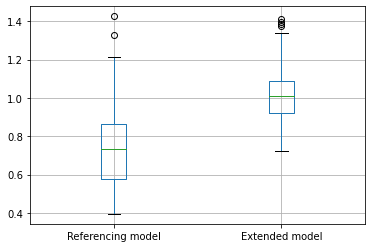

In [31]:
df_com2 = pd.DataFrame()
df_com2['Referencing model'] = (df_sim_b['sum_sharp_turn_diff']/df_sim_b['no_sharp_turn'])
df_com2['Extended model'] =(df_sim['sum_sharp_turn_diff']/df_sim['no_sharp_turn'])

df_com2.boxplot()

In [32]:
df_com2.describe()

,Referencing model,Extended model
count,264.000000,1000.000000
mean,0.713462,1.008693
std,0.213340,0.120098
min,0.394751,0.724731
25%,0.577324,0.919388
50%,0.734425,1.008883
75%,0.861412,1.090033
max,1.425631,1.412958


In [40]:
stats.ttest_ind(df_com2[~df_com2['Referencing model'].isna()]['Referencing model'], df_com2['Extended model'], trim=.2)

Ttest_indResult(statistic=-27.482035694697988, pvalue=6.598461384493642e-116)

In [55]:
def modified_rule2(nx, ny, a, s, k, lm, tx, ty):
    '''
    "modified_rule" calculates the proabability of a single individual to choose option x or left in this project
    based on the modified formula shown above. Three additional parameters are added to the modified formula; lm, tx, and ty.
    tx and ty are used to calculate the decaying rate of nx and ny, respectively. The higher the value of tx (or ty) becomes, 
    the lower the effect of nx (or ny, respectively) becomes. The decaying rate is determined by parameter lm.
    Also, the decaying rate is exponentially increaesd with the sqaure of tx (or ty, respectively).
    Note that either tx or ty could be greater than zero meaning they are set back to zero where each individual gets rewards or chooses the opposite option.
    
    : param nx: the number of individual who chooses option x (or left in this project)
    : param ny: the number of individual who chooses option y (or right in this project)
    : param a: the strength of non-social information (the effect of other factors)
    : param s: the strength of social information from other individuals (i.e., information from nx and ny)
    : param k: the relative impacts of individuals who chose opposite option (i.e., option y)
    : param lm: the decaying rate parameter of nx (or ny) with regard to tx (or ty, respectively)
    : param tx: the elapsed time without any rewards while choosing and moving to option x
    : param ty: the elapsed time without any rewards while choosing and moving to option y   
    
    : return: The proability of a single individual to choose option x
    '''
    
    # if both tx and ty are greater than zero, return None
    if tx*ty!=0:
        return None
    
    # Calculating the probability of a single individual to chooses option x based on the formula
    decay_x = np.exp(-np.power(tx, 2)/(np.power(lm, 2)))
    decay_y = np.exp(-np.power(ty, 2)/(np.power(lm, 2)))
    dx = decay_y*(1 + a*np.float_power(s, -(nx-k*ny)))
    dy = decay_x*(1 + a*np.float_power(s, -(ny-k*nx)))    
    px = 1/(1+(dx/dy))
    
    return px

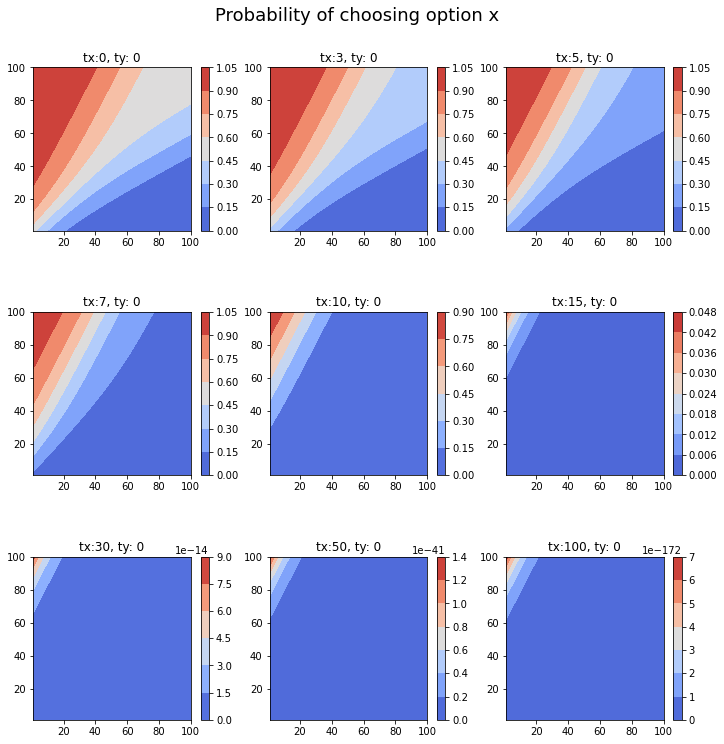

In [56]:
# Setting parameters
no_x = 100
no_y = 100
a = 2.5
s = 1.10
k = 0.53
lm = 5
txty_lst = [(0, 0), (3, 0), (5, 0), (7, 0), (10, 0), (15, 0), (30, 0), (50, 0), (100, 0)]

# Setting axes
x_axis = np.linspace(1, no_x, no_x)
y_axis = np.linspace(1, no_y, no_y)

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Probability of choosing option x", fontsize=18, y=0.95)

# Plot p_matrix for each (tx, ty) pair 
for txty, ax in zip(txty_lst, axs.ravel()):
    (tx, ty) = txty
    
    # Initializing a matrix
    p_matrix = np.empty([no_x, no_y])
    
    # Calculating probabilities for every pair of nx and ny
    for x in range(no_x):
        for y in range(no_y):
            nx = x+1
            ny = y+1

            px = modified_rule2(nx, ny, a, s, k, lm, tx, ty)
            p_matrix[x, y] = px
    
    # Plotting the p_matrix
    im = ax.contourf(y_axis, x_axis, p_matrix, cmap='coolwarm')
    ax.title.set_text('tx:' + str(tx) + ', ty: ' + str(ty))
    plt.colorbar(im, ax=ax)

plt.show()